# Unsupervised outliers detection (event detection)

In [1]:
import pymce as mce

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA,TruncatedSVD,NMF,FastICA
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
from matplotlib import gridspec
%matplotlib inline

## Defining clustering algorithm as clustering fucntion

In [2]:
agg = AgglomerativeClustering(n_clusters=2,
            affinity='euclidean', connectivity=None,
            compute_full_tree='auto', linkage='ward')

def clustering(z_mu):
    num = z_mu.shape[0]
    n_divide = int(num/4999)+1
    y = np.zeros(num)
    for inds in np.array_split(np.arange(num), n_divide):
        y[inds] = agg.fit_predict(z_mu[inds,:])
    return y

metrics = mce.metrics

## Signal synthesis

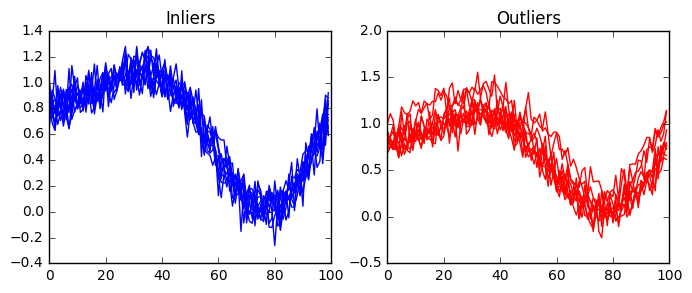

In [3]:
i_sig = 1
n_ftrs = 100
noise = 0.1
scl = 0.0
sft = 0.0

X, y = mce.synt_event(i_sig,n_ftrs,sigma = noise,n1 = scl,n2 = sft,n3 = scl,n4 = sft)

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(8,3)) 
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.set_title('Inliers')
ax2.set_title('Outliers')

inliers = X[y==0]
outliers = X[y==1]
for i in range(10):
    ax1.plot(inliers[i],'b')
    ax2.plot(outliers[i],'r')

## Outlier detection using auto encoders

In [4]:
# encoder\decored architecture definition
nn_en = [n_ftrs, n_ftrs//2, 2]
nn_de = [2, n_ftrs//2, n_ftrs]
network_architecture = [nn_en,nn_de]

dim_rs ={'AE':'AE','VAE':'VAE'}

for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition
    splitter = mce.Splitter(X, value, network_architecture, clustering)

    # Splitting
    splitter.split(1,verbose=0,training_epochs=20)
    
    # outlier extraction for all of requeste metrics
    outliers = mce.outliers(X,splitter,metrics)
        
    # ensembling
    ems_outliers = mce.norm_ensemble(outliers,0.1)
    
    # AUC
    auc = roc_auc_score(y==1, ems_outliers)

    print '{}: AUC={:4.2f}'.format(dim_r,auc)

    print '...........     metric report     ...........'
    print 
    for metr in metrics:
        print metr,roc_auc_score(y==1, outliers[metr])
        
    print '*********************************************'

---------------  AE  ----------------
AE: AUC=0.94
...........     metric report     ...........

cityblock 0.99897
L2 0.982465
L4 0.876825
braycurtis 0.949625
canberra 0.54026
chebyshev 0.725765
correlation 0.63923
mahalanobis 0.96882
wL2 0.982465
wL4 0.876825
*********************************************
---------------  VAE  ----------------
VAE: AUC=0.92
...........     metric report     ...........

cityblock 0.944755
L2 0.928185
L4 0.89809
braycurtis 0.848765
canberra 0.541345
chebyshev 0.814935
correlation 0.941435
mahalanobis 0.894165
wL2 0.924555
wL4 0.89541
*********************************************


## Outlier detection using Scikit-learn dimensionality reduction classes

In [5]:
dim_rs ={'PCA':PCA(n_components=2),
         'NMF':NMF(n_components=2), 
         'FastICA':FastICA(n_components=2, max_iter=1000)}

for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition using Scikit-learn dimensionality reduction classes
    splitter = mce.Custom_Splitter(X, mce.sk_convert(value), clustering)

    # Splitting
    splitter.split(1,verbose=0)
    
    # outlier extraction for all of requeste metrics
    outliers = mce.outliers(X,splitter,metrics)
        
    # ensembling
    ems_outliers = mce.norm_ensemble(outliers,0.1)
    
    # AUC
    auc = roc_auc_score(y==1, ems_outliers)

    print '{}: AUC={:4.2f}'.format(dim_r,auc)

    print '...........     metric report     ...........'
    print 
    for metr in metrics:
        print metr,roc_auc_score(y==1, outliers[metr])
        
    print '*********************************************'

---------------  NMF  ----------------
NMF: AUC=0.87
...........     metric report     ...........

cityblock 0.895875
L2 0.9086
L4 0.89629
braycurtis 0.750955
canberra 0.54297
chebyshev 0.7888
correlation 0.921615
mahalanobis 0.84203
wL2 0.923945
wL4 0.91154
*********************************************
---------------  PCA  ----------------
PCA: AUC=0.97
...........     metric report     ...........

cityblock 0.98699
L2 0.972135
L4 0.945225
braycurtis 0.95363
canberra 0.60455
chebyshev 0.83529
correlation 0.91502
mahalanobis 0.95359
wL2 0.945895
wL4 0.86235
*********************************************
---------------  FastICA  ----------------
FastICA: AUC=0.85
...........     metric report     ...........

cityblock 0.897925
L2 0.908235
L4 0.894785
braycurtis 0.757515
canberra 0.541015
chebyshev 0.793305
correlation 0.927155
mahalanobis 0.95359
wL2 0.752055
wL4 0.75392
*********************************************
